# WSOL - CAM
---

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

In [2]:
%reset -f
%matplotlib inline

# Imports

In [3]:
from src.utils.plot import imshow
from src.utils.preprocess import to_grid
from src.utils.cmap import parula_map
from src.utils.decorator import HiddenPrints
from concurrent.futures import ThreadPoolExecutor
from src.utils.preprocess import image2axial
from src.cam import CAM
from src.classifier.agent import Agent,ThreadSafeReloadedModel
from src.utils import preprocess


import seaborn as sns
import sys,os
import warnings
import nibabel as nib
import numpy as np
import itertools
import torchcam
import torch
import matplotlib.pyplot as plt

# Variables

In [4]:
FILE_NAMES = ['../data/SPM_categorised/AIH/AD/AD_ADNI_2489.nii', '../data/SPM_categorised/AIH/MCI/MCI_ADNI_1389.nii', '../data/SPM_categorised/AIH/CN/CN_ADNI_0442.nii']

MODEL_CHECKPOINT = "/var/metrics/codetests/logs/tb/final/resnet18_brew2/20210524192415/version_0/checkpoints/epoch=52-step=2808.ckpt"

NUM_WORKERS=4
NUM_TRIALS = 10
OBSERVED_CLASSES = [0,1,2]

TARGET_LAYER = "model.layer4"

THREADSAFE_CAM_EXTRACTOR = ThreadSafeReloadedModel(MODEL_CHECKPOINT, cam_type=torchcam.cams.GradCAMpp)
SMOOTHGRADCAMPP_KWARGS = {"std":1}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


# Evaluation

## Average CAM per Class

In [5]:
def trial_classes(extractor, images, classes=[0,1,2],num_trials=10):
    #extractor = self.get_cam(model, self.CAM_TYPE)
    iteration = 1
    for img_index, image in enumerate(images):
        masks = []

        for i in range(num_trials):
            print(f"Running trial: {iteration:2.0f}/{num_trials*len(images):2.0f}", end="\r")

            cam_extractor = extractor()

            class_scores, class_idx = cam_extractor.class_score(image)

            masks.append(torch.stack([
                preprocess.to_grid(preprocess.preprocess_image(cam_extractor.activations(idx, class_scores)))
                for idx in classes
            ]))
            iteration += 1
    return cam_extractor.average_image(masks)

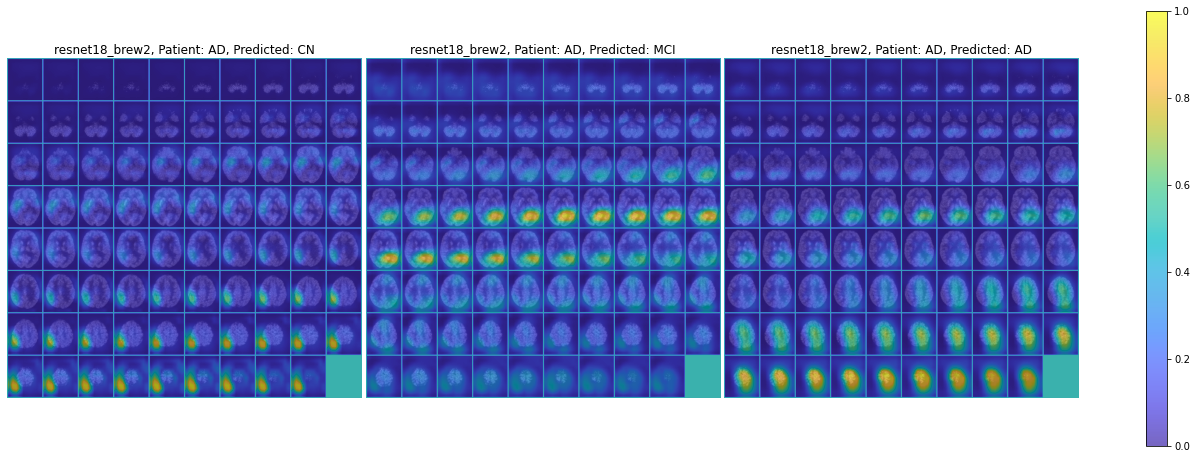

In [10]:
IMAGES = [CAM.preprocess(FILE_NAMES[0])]
class_average = trial_classes(THREADSAFE_CAM_EXTRACTOR, IMAGES)

fig = CAM.plot(
    images=CAM.repeat_stack(CAM.preprocess(FILE_NAMES[0]), repeat=3),
    masks=class_average,
    labels=[0,1,2], 
    class_label="AD",
    architecture="/var/metrics/codetests/logs/tb/final/base2/resnet18_brew2/20210524224031/version_2/checkpoints/epoch=40-step=2172.ckpt".split("/")[8]
);

## Evaluate CAM distribution

In [11]:
def trial_average(extractor, images:list=[], num_trials:int=10):
        iteration = 1
        masks = []
        for img_index, image in enumerate(images):
            for i in range(num_trials):
                print(f"Running trial: {iteration:2.0f}/{num_trials*len(images):2.0f}", end="\r")
            
                cam_extractor = extractor()

                class_scores, class_idx = cam_extractor.class_score(image)
                masks.append(cam_extractor.activations(class_idx, class_scores))
                iteration += 1

        return preprocess.preprocess_image(CAM.average_image(masks))

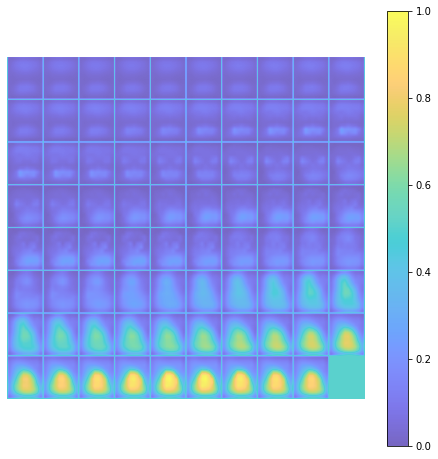

In [14]:
IMAGES = [image[1].squeeze(0) for image in THREADSAFE_CAM_EXTRACTOR.get_validation_images(observe_classes=OBSERVED_CLASSES)]
averaged_mask = trial_average(THREADSAFE_CAM_EXTRACTOR, IMAGES)

fig = CAM.plot(
    masks=torch.stack([preprocess.to_grid(averaged_mask)])
);

Text(0.5, 1.0, 'Density vs intensity plot on CAM')

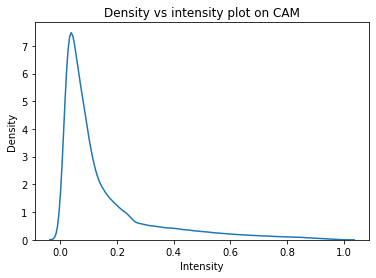

In [15]:
plt.figure()
sns.kdeplot(np.hstack(np.hstack(averaged_mask)))
plt.xlabel("Intensity")
plt.ylabel("Density")
plt.title("Density vs intensity plot on CAM")

Text(0.5, 1.0, 'Density vs intensity plot on CAM')

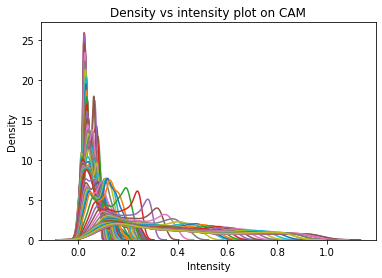

In [16]:
# Show density of each image
[sns.kdeplot(np.hstack(image)) for image in averaged_mask];
plt.xlabel("Intensity")
plt.ylabel("Density")
plt.title("Density vs intensity plot on CAM")

# Grad-CAM++ vs Smooth Grad-CAM++

Testing with Grad-CAM++

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


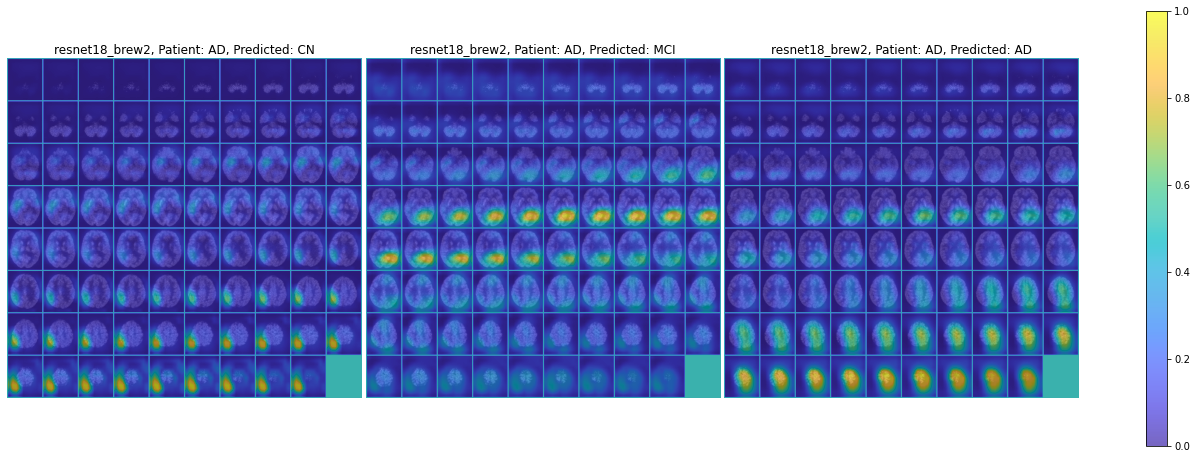

In [21]:
IMAGES = [CAM.preprocess(FILE_NAMES[0])]
class_average = trial_classes(ThreadSafeReloadedModel(MODEL_CHECKPOINT, cam_type=torchcam.cams.GradCAMpp), IMAGES)

fig = CAM.plot(
    images=CAM.repeat_stack(CAM.preprocess(FILE_NAMES[0]), repeat=3),
    masks=class_average,
    labels=[0,1,2], 
    class_label="AD",
    architecture="/var/metrics/codetests/logs/tb/final/base2/resnet18_brew2/20210524224031/version_2/checkpoints/epoch=40-step=2172.ckpt".split("/")[8]
);

Testing with Smooth Grad-CAM++

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


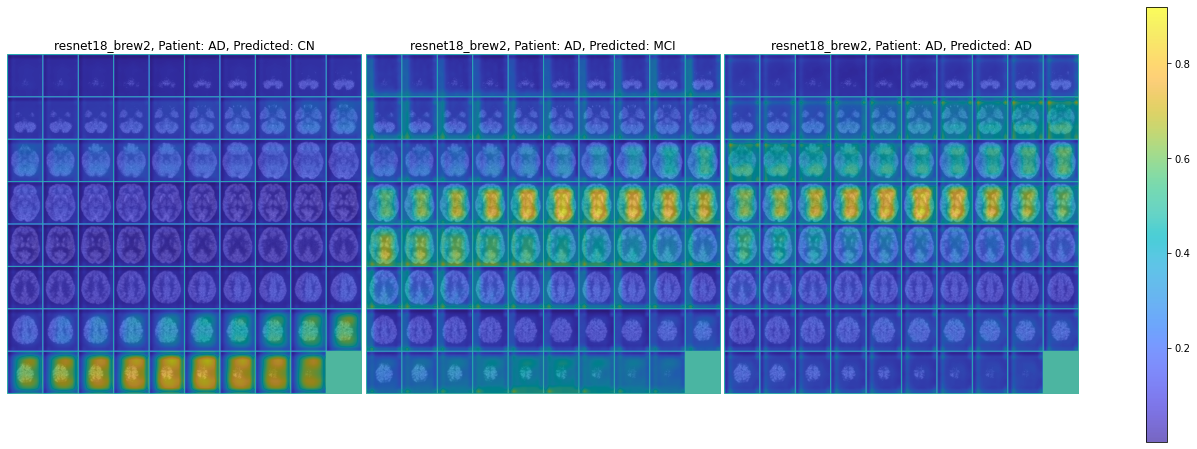

In [23]:
class_average = trial_classes(ThreadSafeReloadedModel(MODEL_CHECKPOINT, cam_type=torchcam.cams.SmoothGradCAMpp, cam_kwargs=SMOOTHGRADCAMPP_KWARGS), IMAGES)

fig = CAM.plot(
    images=CAM.repeat_stack(CAM.preprocess(FILE_NAMES[0]), repeat=3),
    masks=class_average,
    labels=[0,1,2], 
    class_label="AD",
    architecture="/var/metrics/codetests/logs/tb/final/base2/resnet18_brew2/20210524224031/version_2/checkpoints/epoch=40-step=2172.ckpt".split("/")[8]
);